# Tutorial 0: Data Preparation

This notebook covers the two essential data preparation steps before running any GRB population inference:

**A.** Loading and creating Fermi-GBM catalogue data  
**B.** Preparing redshift samples from Merger Rate Density (MRD) models

The outputs of this notebook will be used as inputs for the subsequent tutorials.

---

## Part A: Loading and Creating GBM Data

We use the `gdt-fermi` package (Fermi GBM Data Tools) to access the official Fermi-GBM Burst Catalog. This provides observed short GRB properties (peak flux, T90, fluence, peak energy) that serve as the observational constraints for our MCMC inference.

### Step 1: Initialize the Burst Catalog

In [1]:
from gdt.missions.fermi.gbm.catalogs import BurstCatalog
import numpy as np
import matplotlib.pyplot as plt

# Initialize the Fermi-GBM burst catalog (downloads from HEASARC)
burstcat = BurstCatalog()
print(f"Total GRBs in catalogue: {burstcat.num_rows}")

Sending request and awaiting response from HEASARC...
Finished in 76 s
Total GRBs in catalogue: 4218


### Step 2: Inspect Available Columns

The catalogue contains many columns see the official Fermi website [here](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermigbrst.html) for more details. The key observables for our analysis are:
- **`FLUX_BATSE_64`**: Peak photon flux in the 50–300 keV band (64 ms timescale)
- **`T90`**: Duration of the burst (time containing 90% of the fluence)
- **`FLUENCE_BATSE`**: Total fluence in the 50–300 keV band
- **`PFLX_COMP_EPEAK`**: Peak energy from the spectral fit

In [2]:
cols = [c.upper() for c in ["T90", "Flux_BATSE_64", "Fluence_BATSE", "Pflx_Comp_Epeak", "Trigger_Time"]]
burstcat.get_table(cols)

rec.array([( 4.288,  0.6028, 1.2524e-07, 205.7393, 56020.856927  ),
           (17.408, 11.1926, 1.3652e-05, 204.6519, 55984.72547517),
           (11.008,  2.6118, 8.9879e-07, 115.3316, 60088.35730917), ...,
           (55.553,  4.7233, 6.6111e-06, 230.347 , 56440.6954214 ),
           ( 7.552, 15.1617, 1.8073e-06, 157.2283, 55056.17410408),
           ( 8.192,  3.2791, 1.6901e-06, 559.1635, 55593.39942421)],
          dtype=[('T90', '<f8'), ('FLUX_BATSE_64', '<f8'), ('FLUENCE_BATSE', '<f8'), ('PFLX_COMP_EPEAK', '<f8'), ('TRIGGER_TIME', '<f8')])

### Step 3: Apply Selection Cuts

We select **short GRBs** ($T_{90} < 2\,\text{s}$) with a peak flux above a completeness threshold ($F_p > 4\,\text{ph/cm}^2/\text{s}$). These cuts define the "triggered" sample that our Monte Carlo must reproduce. We additionally add a quality cut $E_{\text{peak}} \in [50, 10^4]\,\text{keV}$.

In [3]:
# Define selection cuts
cond_t90  = ("T90",           0, 2)       # Short GRBs: T90 < 2s
cond_flux = ("Flux_BATSE_64", 4, 10_000)  # Peak flux > 4 ph/cm^2/s (completeness), the upper bound is arbitrary 
cond_energy = ("Pflx_Comp_Epeak"  , 50, 10_000) # Quality cut 

triggered_table = burstcat.slices([cond_flux, cond_t90])
quality_table   = burstcat.slices([cond_flux, cond_t90, cond_energy])

# Calculate the observation time and event rate
times       = triggered_table.get_table(columns=("trigger_time", "T90"))
trig_time   = times['TRIGGER_TIME']
trig_time_quality = quality_table.get_table(columns=("trigger_time", "T90"))['TRIGGER_TIME']

days_year   = 365.25
years       = (max(trig_time) - min(trig_time)) / days_year
event_rate  = len(trig_time) / years
event_rate_quality = len(trig_time_quality) / years

print(f"Total short GRBs passing cuts: {len(trig_time)}")
print(f"Observation span: {years:.2f} years")
print(f"Event rate: {event_rate:.2f} events/yr")
print(f"Event rate (quality cut): {event_rate_quality:.2f} events/yr")

from astropy.time import Time
# Convert trigger times from MET to UTC for display
trigger_times_utc = Time(trig_time, format='mjd', scale='tai').utc
print(f"First trigger time (UTC): {trigger_times_utc[0].iso}")
print(f"Last trigger time (UTC): {trigger_times_utc[-1].iso}")

Total short GRBs passing cuts: 325
Observation span: 17.50 years
Event rate: 18.58 events/yr
Event rate (quality cut): 15.32 events/yr
First trigger time (UTC): 2024-01-19 17:28:30.684
Last trigger time (UTC): 2009-10-12 18:46:28.770


### Step 4: Extract and Save the Catalogue

We save the filtered catalogue in two formats:
1. A `.txt` file with the 4 key observables (used by the MC likelihood)
2. A `.dat` CSV with all short GRBs (used by `catalogue_prep` in `src.data_io`)

In [4]:
import pandas as pd

# --- Save the filtered (triggered + fitted) catalogue as .txt ---
table_to_save = triggered_table.get_table(
    columns=("Flux_BATSE_64", "T90", "Fluence_BATSE", "Pflx_Comp_Epeak")
)

ev_rate_string = f"{event_rate:.2f}".replace(".", "_")
txt_filename = f"../datafiles/fermi_catalogue_plim_4_t90_2_rate_{ev_rate_string}.txt" # This isn't used in the MC but is usefull for plots

np.savetxt(txt_filename, table_to_save)
print(f"Saved triggered catalogue to: {txt_filename}")

# --- Save ALL short GRBs (T90 < 2s, no flux cut) as .dat for catalogue_prep ---
cond_all_short = ("T90", 0, 2)
all_short_table = burstcat.slices([cond_all_short])
all_cols = ("Flux_BATSE_64", "T90", "Fluence_BATSE", "Pflx_Comp_Epeak", "TRIGGER_TIME")
all_table = all_short_table.get_table(columns=all_cols)

table_df = pd.DataFrame(all_table)
dat_filename = "../datafiles/burst_catalog.dat"
table_df.to_csv(dat_filename, index=False)
print(f"Saved full short GRB catalogue ({len(table_df)} rows) to: {dat_filename}")

Saved triggered catalogue to: ../datafiles/fermi_catalogue_plim_4_t90_2_rate_18_58.txt
Saved full short GRB catalogue (706 rows) to: ../datafiles/burst_catalog.dat


### Step 5: Visualize the Catalogue

A corner plot of the four key observables provides a quick sanity check of the data.

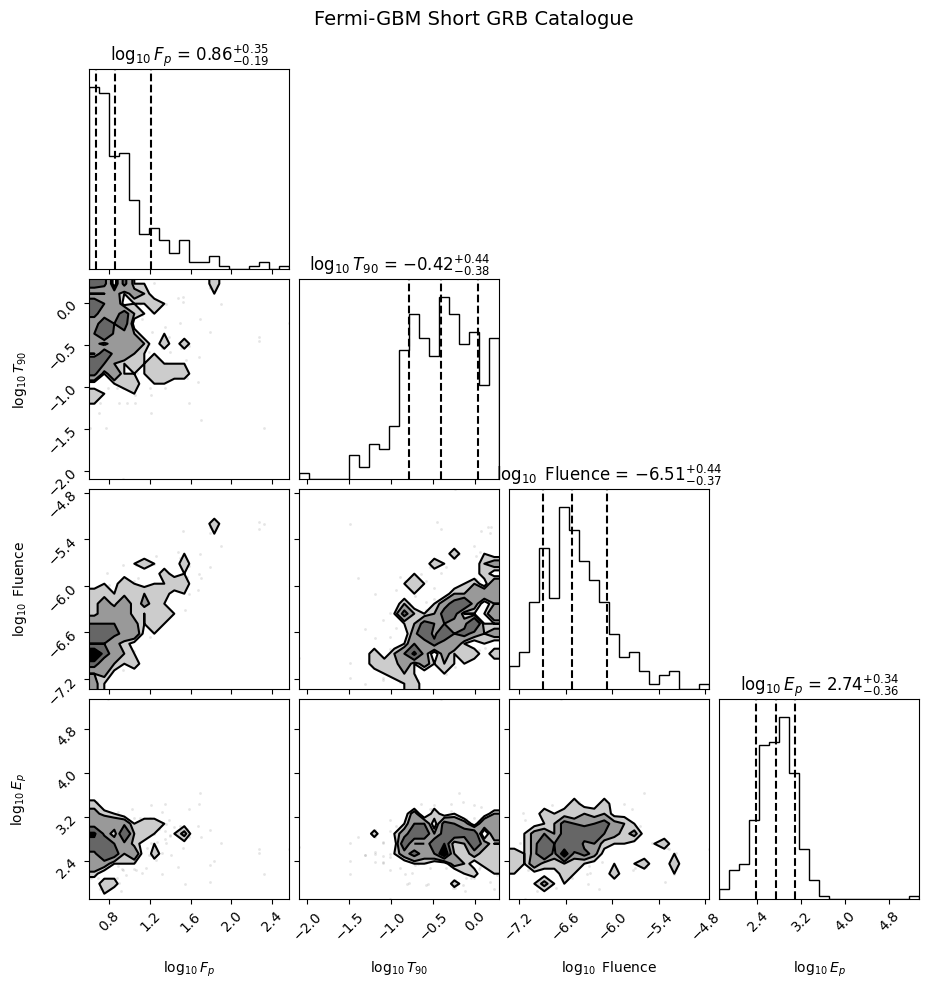

In [5]:
import corner

loaded_data = np.loadtxt(txt_filename)

epeak_linear = loaded_data[:, 3]
mask = epeak_linear > 0
pflx    = np.log10(loaded_data[:, 0][mask])
t90     = np.log10(loaded_data[:, 1][mask])
fluence = np.log10(loaded_data[:, 2][mask])
epeak   = np.log10(loaded_data[:, 3][mask])

fig = corner.corner(
    np.array([pflx, t90, fluence, epeak]).T,
    labels=[r"$\log_{10} F_p$", r"$\log_{10} T_{90}$", r"$\log_{10}$ Fluence", r"$\log_{10} E_p$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    fill_contours=True,
)
plt.suptitle("Fermi-GBM Short GRB Catalogue", y=1.02, fontsize=14)
plt.show()

---

## Part B: Preparing Redshift Samples

The redshift distribution of BNS mergers is a critical ingredient. We use population synthesis models that predict the Merger Rate Density (MRD) $\mathcal{R}(z)\,[\text{Gpc}^{-3}\text{yr}^{-1}]$.

The probability of a merger at redshift $z$ is:

$$
P(z) = \frac{1}{N_{\text{total}}} \frac{\mathcal{R}(z)}{1+z} \frac{dV_c}{dz}
$$

where $dV_c/dz$ is the differential comoving volume and the $(1+z)^{-1}$ factor accounts for cosmological time dilation (as we are dealing with a rate $\text{yr}^{-1}$).

### Step 1: Load MRD and Sample Redshifts

In [6]:
%load_ext autoreload
%autoreload 2
import notebook_setup

from pathlib import Path
from src.redshift import get_mrd_redshift_distribution, sample_from_mrd

datafiles = Path("../datafiles")

# Load the MRD for a specific population synthesis model
# The model name encodes: population type + common envelope parameter
population  = "fiducial_Hrad"   # Population synthesis model
alpha       = "A1.0"            # Common envelope efficiency
 
P_z_interp, total_rate, local_rate, z_grid, P_z_density = get_mrd_redshift_distribution(
    datafiles=datafiles,
    population=population,
    alpha=alpha,
    component="BNSs"
)

print(f"Local merger rate R_0:  {local_rate:.1f} Gpc^-3 yr^-1")
print(f"Total merger rate:      {total_rate:.0f} yr^-1 (integrated over all z)")

Local merger rate R_0:  112.0 Gpc^-3 yr^-1
Total merger rate:      360833 yr^-1 (integrated over all z)


### Visualizing the Merger Rate Density

Before sampling, let's compare how the MRD $\mathcal{R}(z)$ changes with the common-envelope efficiency parameter $\alpha$ for the fiducial model. Higher $\alpha$ allows more efficient envelope ejection, affecting the delay-time distribution and hence the redshift evolution of the merger rate.

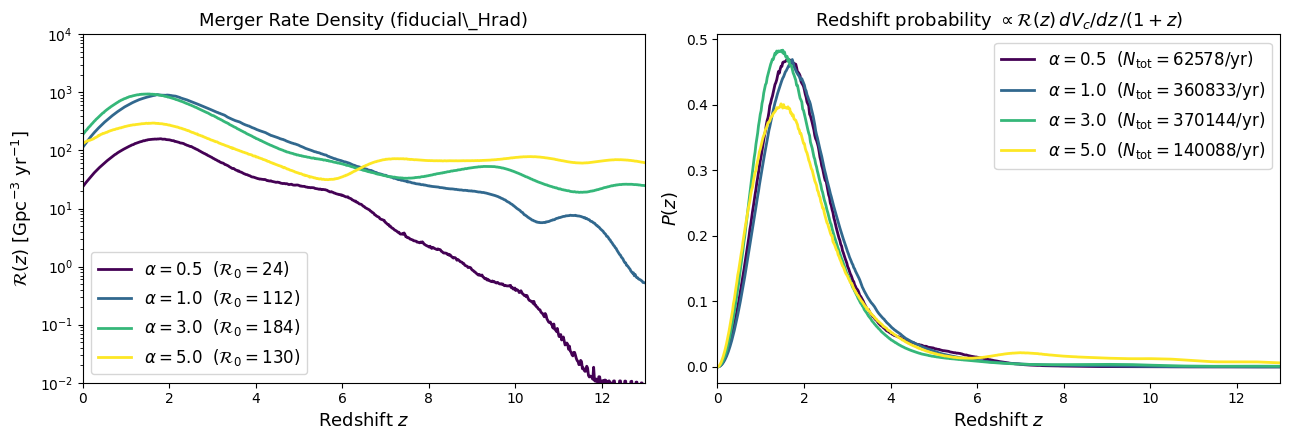

In [7]:
from src.redshift import get_mrd_redshift_distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

colors = {'A0.5': '#440154', 'A1.0': '#31688e', 'A3.0': '#35b779', 'A5.0': '#fde725'}

for alpha_val in ["A0.5", "A1.0", "A3.0", "A5.0"]:
    P_z_i, total_i, local_i, z_i, Pz_dens_i = get_mrd_redshift_distribution(
        datafiles=datafiles,
        population="fiducial_Hrad",
        alpha=alpha_val,
        component="BNSs",
    )
    
    # Left: raw MRD
    mrd_path = (datafiles / "populations" / "MRD" / "output_sigma0.1" /
                "fiducial_Hrad" / alpha_val / "BNSs" /
                "MRD_spread_15Z_40_No_MandF2017_0.1_No_No_0.dat")
    z_mrd, mrd = np.loadtxt(mrd_path, unpack=True)
    
    label = rf'$\alpha = {alpha_val[1:]}$  ($\mathcal{{R}}_0 = {local_i:.0f}$)'
    ax1.semilogy(z_mrd, mrd, lw=2, color=colors[alpha_val], label=label)
    
    # Right: P(z) probability density
    ax2.plot(z_i, Pz_dens_i, lw=2, color=colors[alpha_val],
             label=rf'$\alpha = {alpha_val[1:]}$  ($N_\mathrm{{tot}} = {total_i:.0f}$/yr)')

ax1.set_xlabel('Redshift $z$', fontsize=13)
ax1.set_ylabel(r'$\mathcal{R}(z)$ [Gpc$^{-3}$ yr$^{-1}$]', fontsize=13)
ax1.set_title('Merger Rate Density (fiducial\_Hrad)', fontsize=13)
ax1.legend(fontsize=12)
ax1.set_xlim(0, 13)
ax1.set_ylim(1e-2, 1e4)

ax2.set_xlabel('Redshift $z$', fontsize=13)
ax2.set_ylabel('$P(z)$', fontsize=13)
ax2.set_title(r'Redshift probability $\propto \mathcal{R}(z)\,dV_c/dz\,/(1+z)$', fontsize=13)
ax2.legend(fontsize=12)
ax2.set_xlim(0, 13)

plt.tight_layout()
plt.show()

### Step 2: Draw Redshift Samples

We sample from $P(z)$ using inverse CDF sampling. The number of samples corresponds to the expected number of BNS mergers in 1 year across the entire Universe. This is an optimization trick that works due to the large number of mergers, compared to resampling at each step.

In [8]:
rng = np.random.default_rng(42)

# Sample redshifts for ~1 year of BNS mergers
n_samples = int(total_rate)  # One year of mergers
z_samples = sample_from_mrd(P_z_interp, z_grid, P_z_density, n_samples, rng=rng)

print(f"Drew {len(z_samples)} redshift samples")
print(f"Median redshift: {np.median(z_samples):.3f}")

Drew 360832 redshift samples
Median redshift: 1.941


### Step 3: Visualize and Save

We plot the $P(z)$ distribution and the drawn samples, then save them with the identifier **`TEST_A_0.5`** for use in subsequent tutorials.

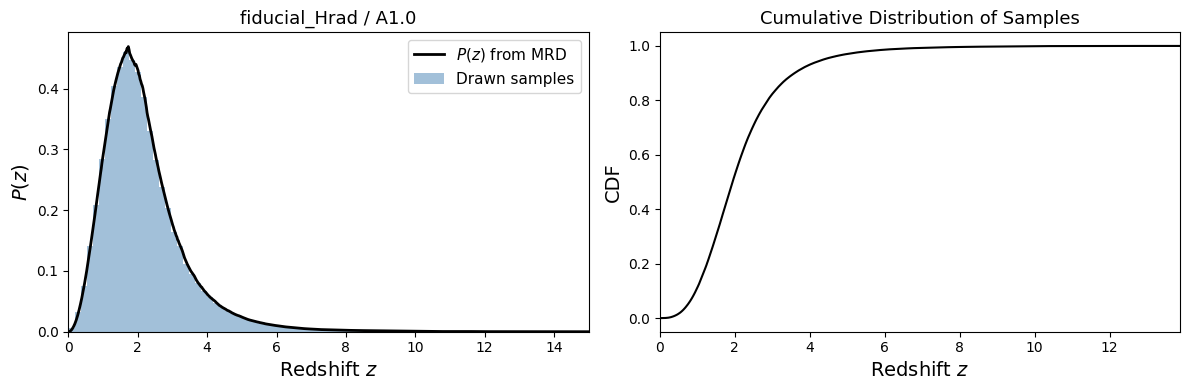

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left: P(z) distribution vs histogram of samples
ax1.plot(z_grid, P_z_density, 'k-', lw=2, label=r'$P(z)$ from MRD')
ax1.hist(z_samples, bins=80, density=True, alpha=0.5, color='steelblue', label='Drawn samples')
ax1.set_xlabel('Redshift $z$', fontsize=14)
ax1.set_ylabel('$P(z)$', fontsize=14)
ax1.set_title(f'{population} / {alpha}', fontsize=13)
ax1.legend(fontsize=11)
ax1.set_xlim(0, z_grid.max())

# Right: Cumulative distribution
z_sorted = np.sort(z_samples)
cdf = np.arange(1, len(z_sorted) + 1) / len(z_sorted)
ax2.plot(z_sorted, cdf, 'k-', lw=1.5)
ax2.set_xlabel('Redshift $z$', fontsize=14)
ax2.set_ylabel('CDF', fontsize=14)
ax2.set_title('Cumulative Distribution of Samples', fontsize=13)
ax2.set_xlim(0, max(z_sorted))
    
plt.tight_layout()
plt.show()

In [10]:
# Save the redshift samples with a recognizable name
sample_name = "TEST_A1.0"
output_path = datafiles / "populations" / "samples" / f"samples_{population}_{sample_name}.dat"
output_path.parent.mkdir(parents=True, exist_ok=True)

np.savetxt(output_path, z_samples)
print(f"Saved {len(z_samples)} redshift samples to: {output_path}")
print(f"\nTo use in subsequent tutorials, set:")
print(f'  params["z_model"] = "{population}_{sample_name}"')

Saved 360832 redshift samples to: ../datafiles/populations/samples/samples_fiducial_Hrad_TEST_A1.0.dat

To use in subsequent tutorials, set:
  params["z_model"] = "fiducial_Hrad_TEST_A1.0"


### Step 4: Verify the Saved Samples

Quick check that the saved file loads correctly and can be found by `initialize_simulation`.

In [11]:
# Verify the file is loadable
z_check = np.loadtxt(output_path)
print(f"Loaded {len(z_check)} samples from {output_path.name}")
print(f"Match: {np.allclose(z_samples, z_check)}")

# List all available redshift samples
sample_dir = datafiles / "populations" / "samples"
available = list(sample_dir.glob("samples*.dat"))
print(f"\nAvailable redshift samples ({len(available)}):")
for f in sorted(available):
    n = len(np.loadtxt(f))
    print(f"  {f.stem}: {n} BNS mergers")

Loaded 360832 samples from samples_fiducial_Hrad_TEST_A1.0.dat
Match: True

Available redshift samples (65):
  samples_fiducial_HGoptimistic_A0.5_BNSs_0: 7636 BNS mergers
  samples_fiducial_HGoptimistic_A1.0_BNSs_0: 57844 BNS mergers
  samples_fiducial_HGoptimistic_A3.0_BNSs_0: 361335 BNS mergers
  samples_fiducial_HGoptimistic_A5.0_BNSs_0: 812489 BNS mergers
  samples_fiducial_Hrad_5M_A0.5_BNSs_0: 63473 BNS mergers
  samples_fiducial_Hrad_5M_A1.0_BNSs_0: 359531 BNS mergers
  samples_fiducial_Hrad_5M_A3.0_BNSs_0: 370949 BNS mergers
  samples_fiducial_Hrad_5M_A5.0_BNSs_0: 145179 BNS mergers
  samples_fiducial_Hrad_A0.5_BNSs_0: 62278 BNS mergers
  samples_fiducial_Hrad_A1.0_BNSs_0: 359079 BNS mergers
  samples_fiducial_Hrad_A3.0_BNSs_0: 368417 BNS mergers
  samples_fiducial_Hrad_A5.0_BNSs_0: 139399 BNS mergers
  samples_fiducial_Hrad_TEST_A1.0: 360832 BNS mergers
  samples_fiducial_delayed_A0.5_BNSs_0: 60187 BNS mergers
  samples_fiducial_delayed_A1.0_BNSs_0: 342071 BNS mergers
  samples

---

## Summary

In this notebook we:

1. **Downloaded and filtered** the Fermi-GBM short GRB catalogue ($T_{90} < 2\,$s, $F_p > 4\,$ph/cm$^2$/s)
2. **Saved** the observational data in the format expected by the likelihood
3. **Loaded a Merger Rate Density** model (`fiducial_Hrad` / `A1.0`)
4. **Sampled redshifts** and saved them as **`TEST_A_1.0`**

In the next tutorials, we will use:
```python
params["z_model"] = "fiducial_Hrad_TEST_A1.0"
```
to load these redshift samples when initializing the simulation.